<a href="https://colab.research.google.com/github/iliapopov17/BI-Workshop-miniProjects/blob/main/Project%209/Lab%20journal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Step 1. Envinronment setup and data import**

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

In [3]:
adata = sc.read_csv(
    '/content/drive/MyDrive/BI9/citeseq_rna_counts.tsv',
    delimiter="\t",
)
adata = adata.T
adata

AnnData object with n_obs × n_vars = 33454 × 17009

### **Step 1.1. Make directory for results**

In [4]:
! mkdir write

mkdir: cannot create directory ‘write’: File exists


In [5]:
results_file = "write/BI9.h5ad"  # the file that will store the analysis results

## **Step 2. Preprocessing**

### **Step 2.1. Quality Control**

How much cells do we have before QC?

In [6]:
print("Cells before:", adata.shape[0])

Cells before: 33454


In [7]:
adata.var_names_make_unique()

In [8]:
adata

AnnData object with n_obs × n_vars = 33454 × 17009

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

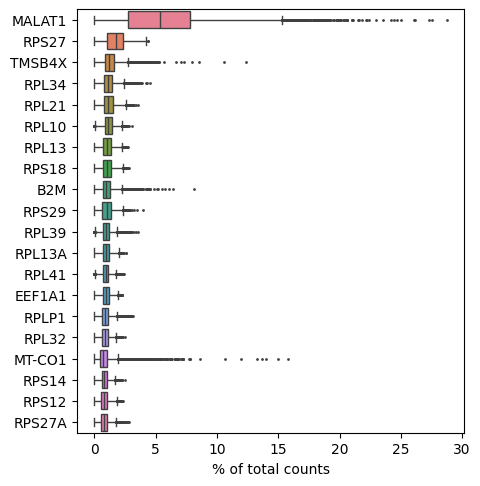

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Let’s assemble some information about mitochondrial genes, which are important for quality control.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [11]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

A violin plot of some of the computed quality measures:
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

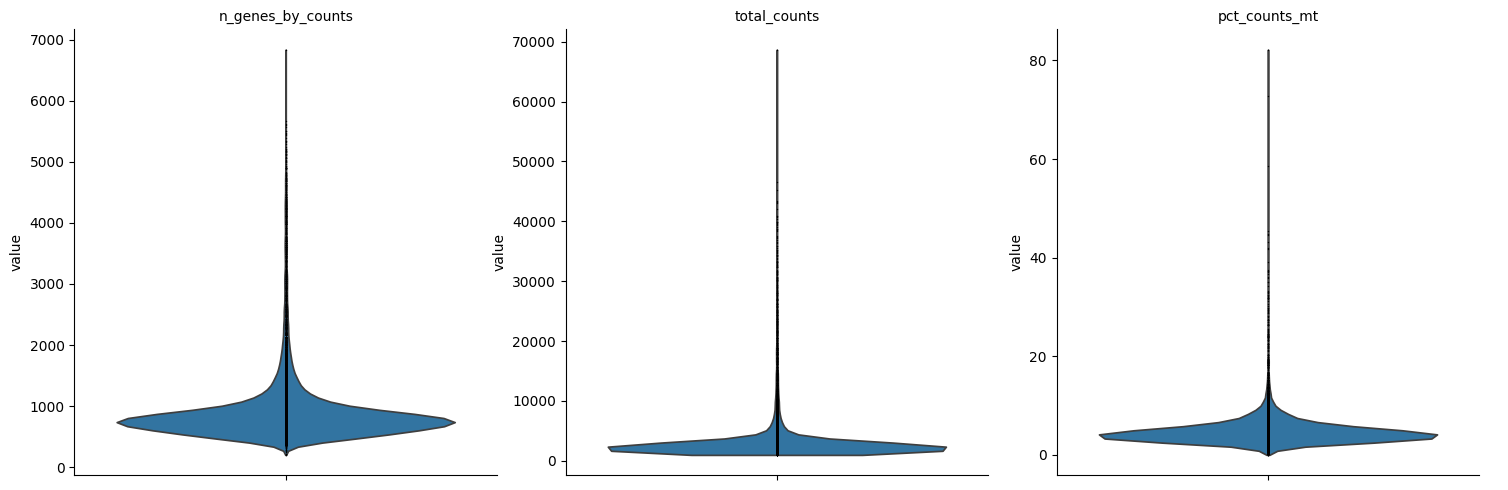

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

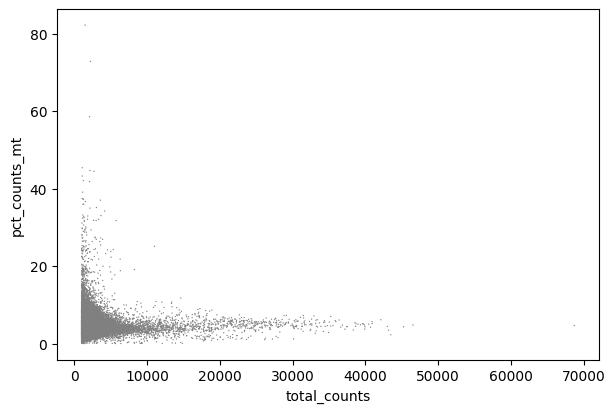

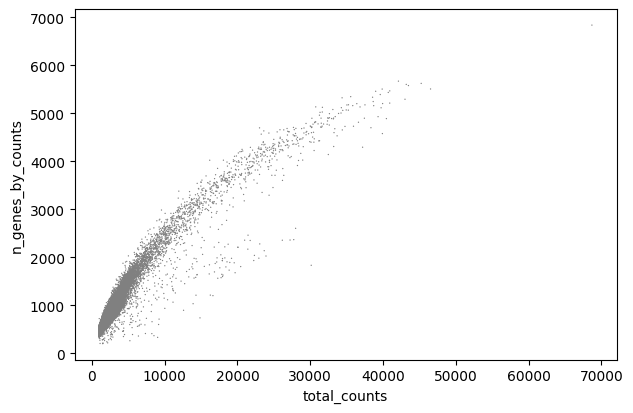

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Actually do the filtering by slicing the `AnnData` object.

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.total_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

Let's visualize QC graphs again:

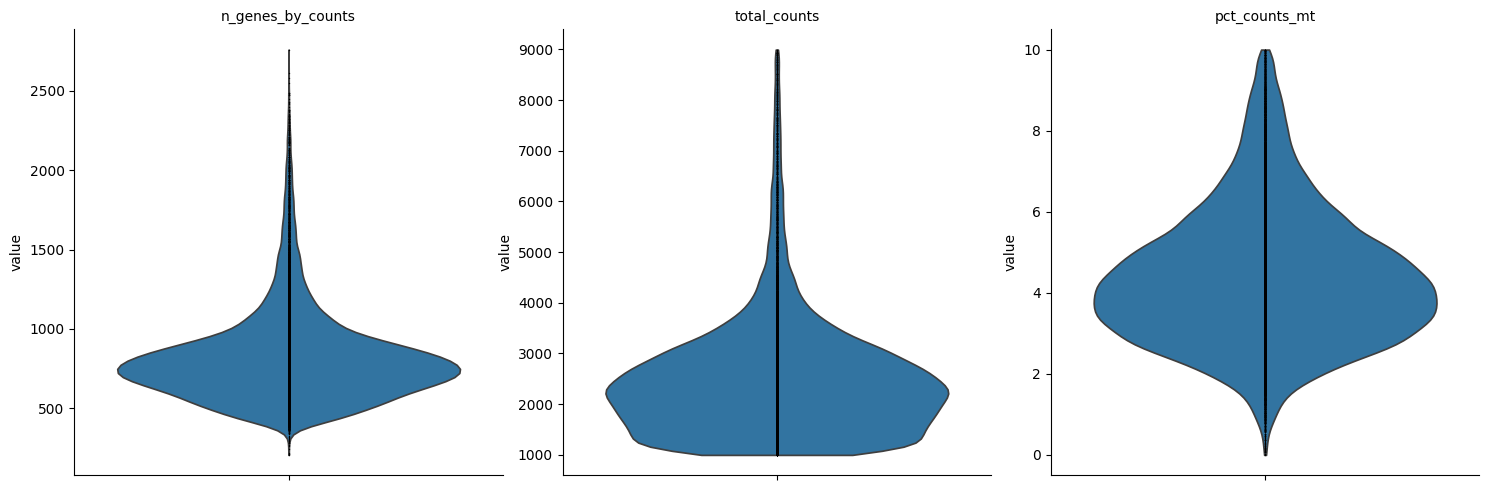

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0,
    multi_panel=True,
)

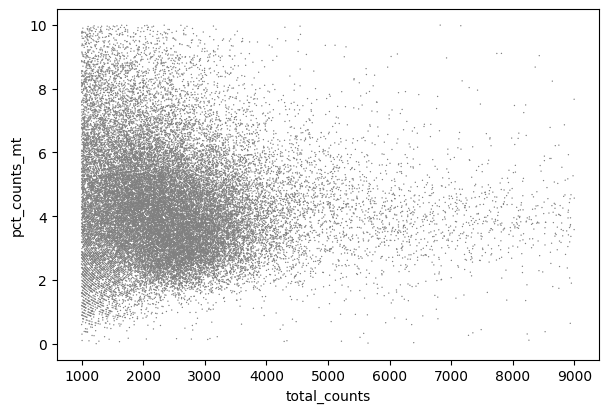

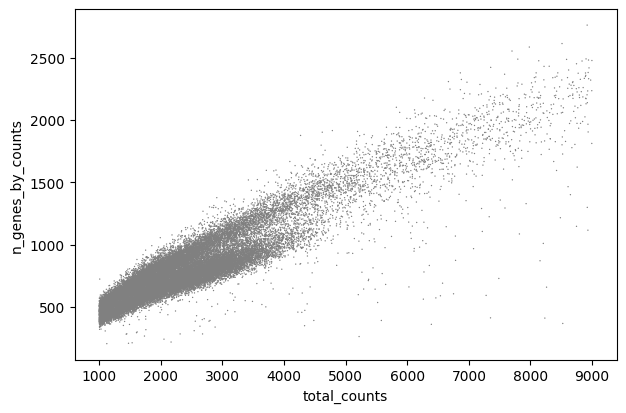

In [16]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

How much cells do we have after QC?

In [17]:
print("Cells after:", adata.shape[0])

Cells after: 31382


Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)

Logarithmize the data:

In [19]:
sc.pp.log1p(adata)

Identify highly-variable genes.

**Explanation of the flavor Parameter**
- `flavor='seurat'`: This method mimics the approach used by Seurat (a popular R package for single-cell data analysis). It automatically selects variable genes based on mean expression and dispersion. It normalizes dispersion by fitting to a model assuming that dispersion is a function of mean expression.

**Benefits of Automatic Parameter Selection**
Using an automatic method like `flavor='seurat'` has several benefits:
- Adaptability: Automatically adapts to different datasets by estimating relevant thresholds based on data distribution.
- Reproducibility: Helps in maintaining consistency across different analyses without needing to manually tweak parameters for each dataset.
- Ease of Use: Simplifies the analysis workflow, especially for those who may not be experts in the nuances of gene expression data.

In [20]:
sc.pp.highly_variable_genes(adata, flavor='seurat')

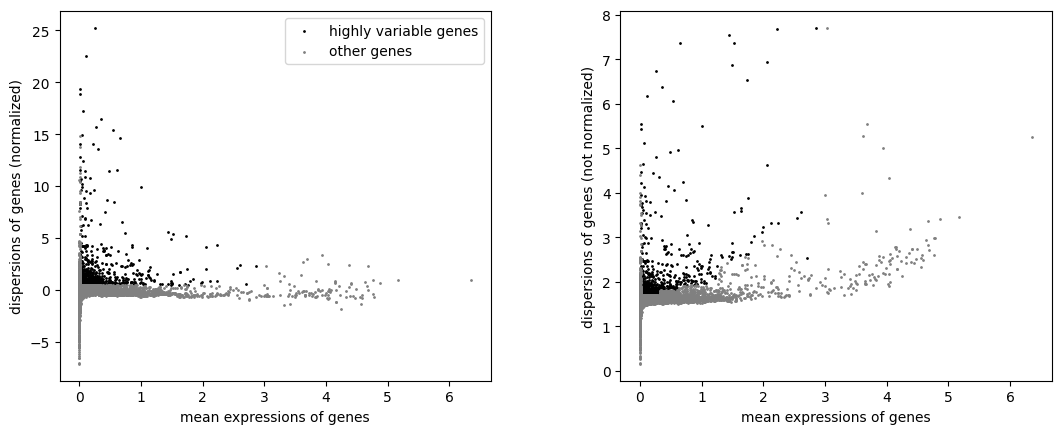

In [21]:
sc.pl.highly_variable_genes(adata)

In terms of using memory more efficient, let us subset dataset to keep only highly variable genes.

In [22]:
sc.pp.highly_variable_genes(adata, flavor='seurat', subset = True)

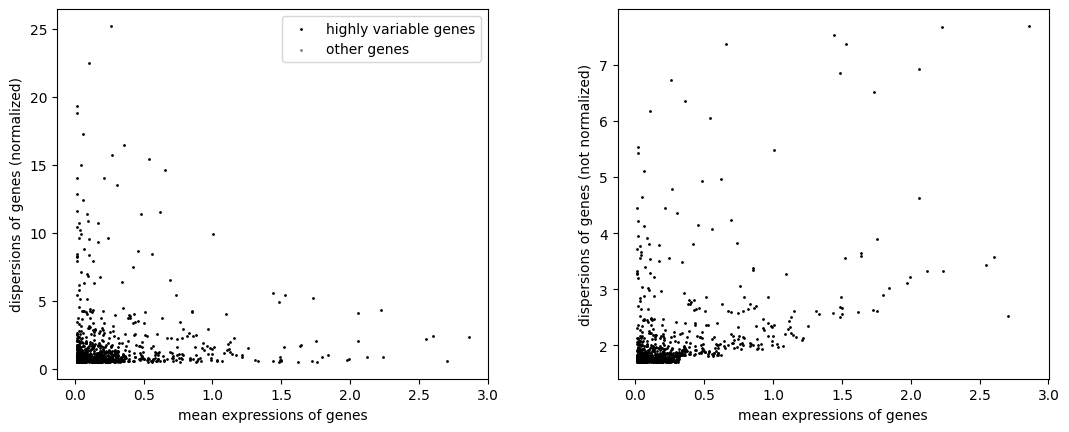

In [23]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

> You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

In [24]:
adata.raw = adata

Actually do the filtering

In [25]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [26]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [27]:
sc.pp.scale(adata, max_value=10)

## **Step 3. Principal component analysis**

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [28]:
sc.tl.pca(adata, svd_solver="arpack")

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

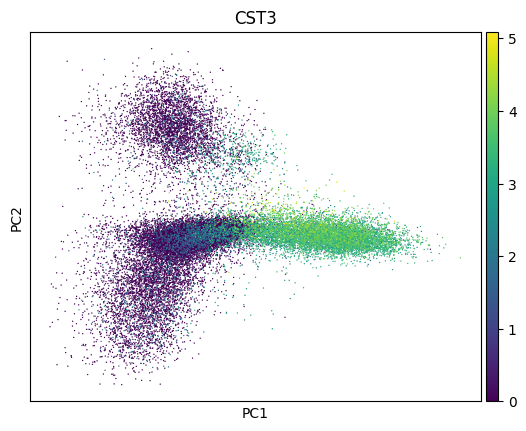

In [29]:
sc.pl.pca(adata, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

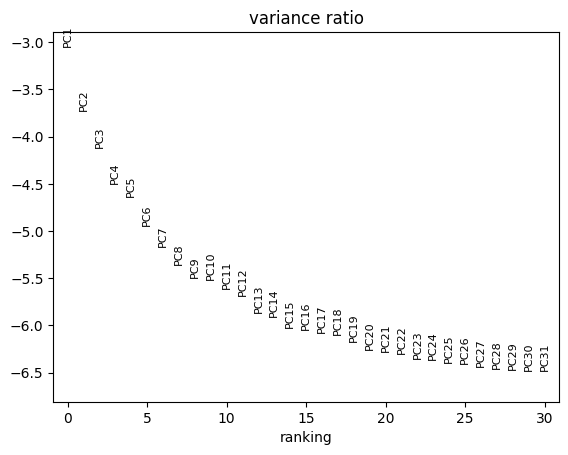

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [31]:
adata.write(results_file)

In [32]:
adata

AnnData object with n_obs × n_vars = 31382 × 1008
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## **Step 4. Computing the neighborhood graph**

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

Scanpy tutorial says:<br>
"You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values."

So that is what I did!

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## **Step 5. Clustering the neighborhood graph**

Resolution = 0.15 is used because at this resolution 8 cells groups can be achieved.

In [34]:
sc.tl.leiden(
    adata,
    resolution=0.15,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

In [35]:
sc.tl.umap(adata)

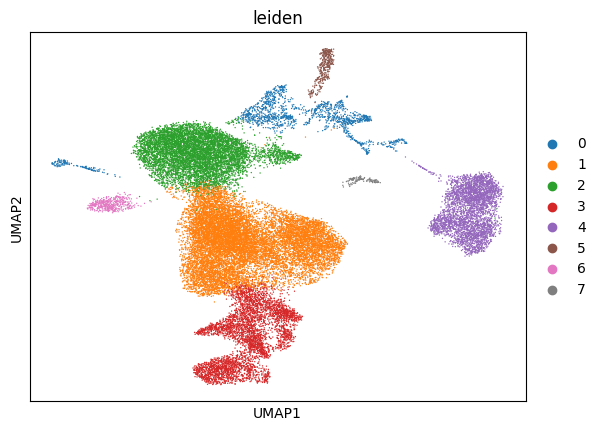

In [36]:
sc.pl.umap(adata, color="leiden")

Save the result.

In [37]:
adata.write(results_file)

## **Step 6. Finding marker genes**

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

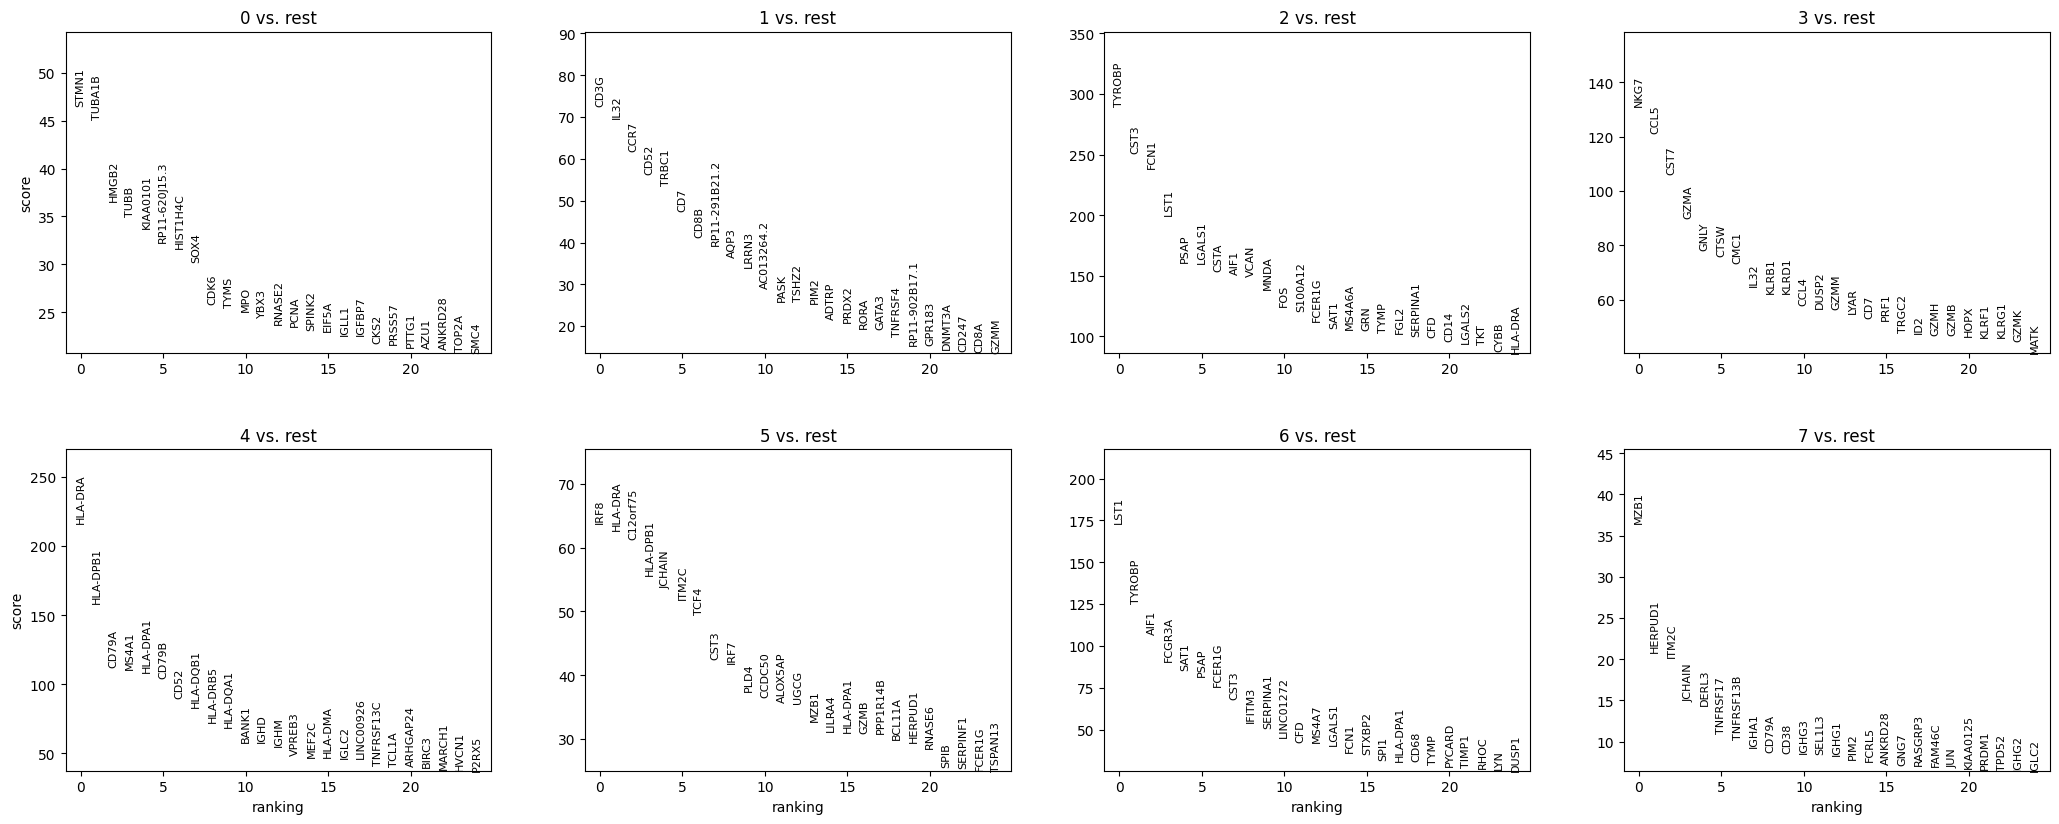

In [38]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [39]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar.

ranking genes
    finished (0:00:02)


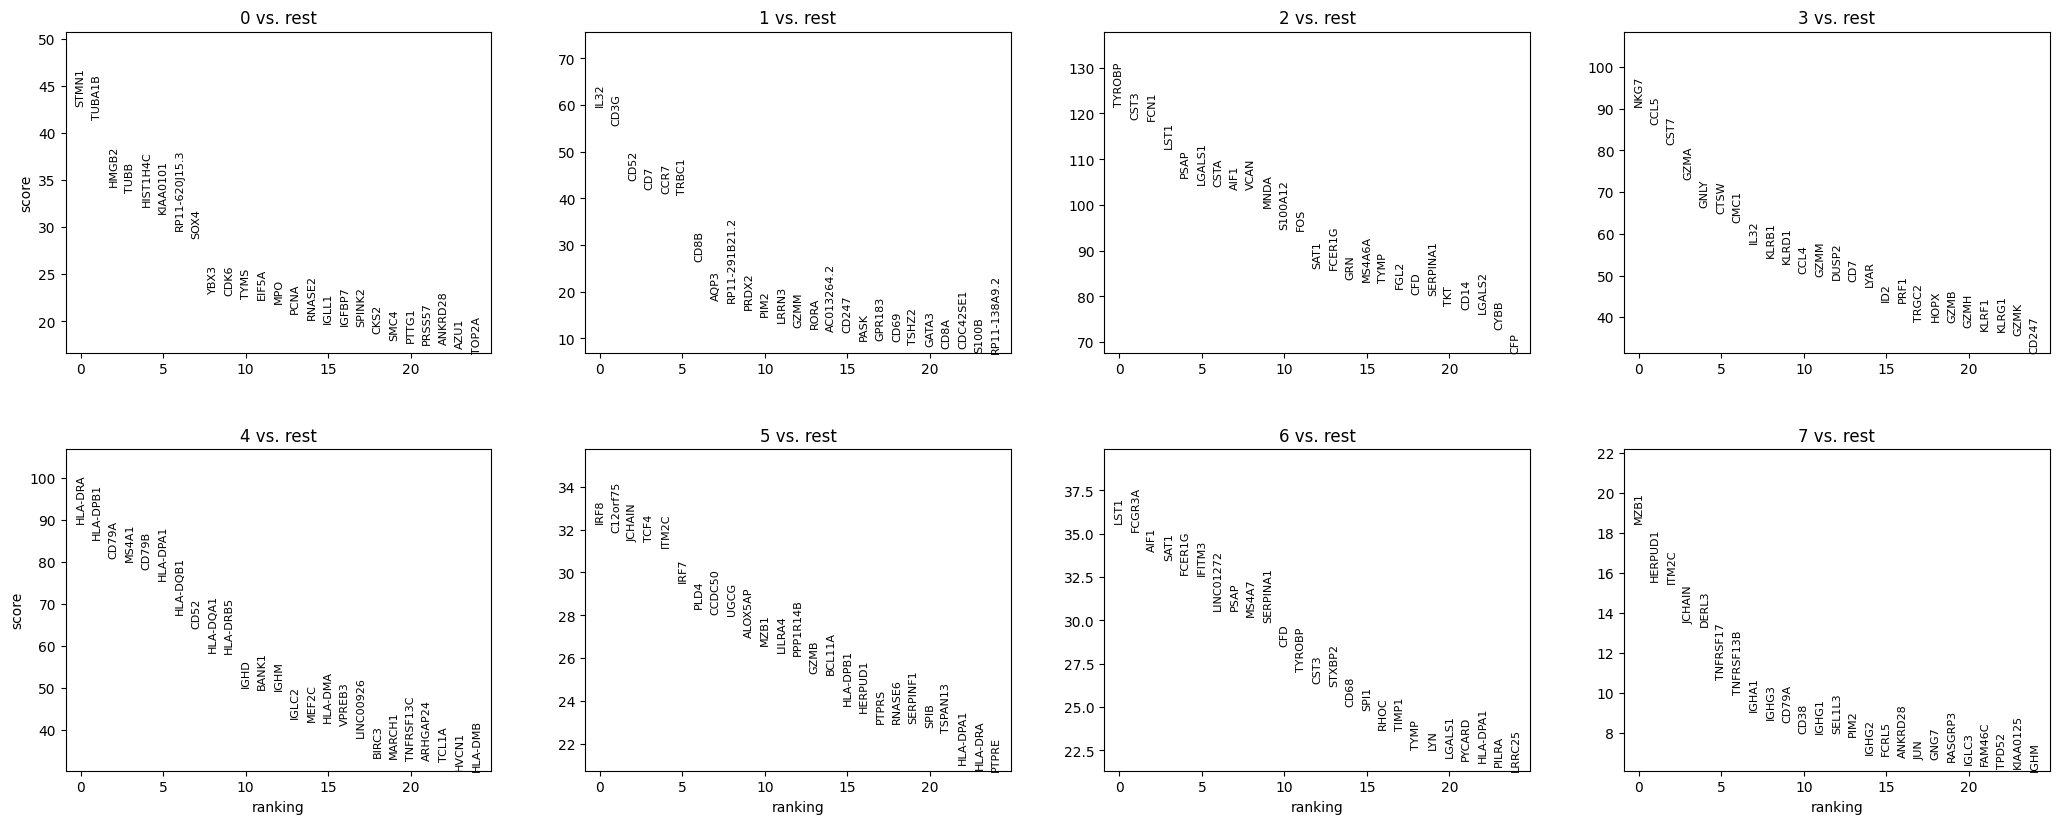

In [40]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [41]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression.

In [45]:
#sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As it takes almost eternity to run logistic regression at 1000 iterations, I will not use it.

I like the results of Wilcoxon rank-sum (Mann-Whitney-U) the most. These are the ones we will use next. The list of marker genes is used from this source: https://aacrjournals.org/cancerimmunolres/article/6/11/1388/468810/Immune-Cell-Gene-Signatures-for-Profiling-the

In [42]:
marker_genes = [
    *["RORA", "CCR7", "PCNA", "TOP2A", "STMN1", "TUBA1B", "CCL5"],
    *["NKG7", "GZMA", "FCN1", "VCAN", "AIF1"],
    *["CD79A", "CD79B", "MS4A1", "IRF8", "TCF4"],
    *["BCL11A", "SPIB", "SPI1", "CD68", "TNFRSF17", "CD38", "IGHG1"],
]

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [43]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [44]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,STMN1,IL32,TYROBP,NKG7,HLA-DRA,IRF8,LST1,MZB1
1,TUBA1B,CD3G,CST3,CCL5,HLA-DPB1,C12orf75,FCGR3A,HERPUD1
2,HMGB2,CD52,FCN1,CST7,CD79A,JCHAIN,AIF1,ITM2C
3,TUBB,CD7,LST1,GZMA,MS4A1,TCF4,SAT1,JCHAIN
4,HIST1H4C,CCR7,PSAP,GNLY,CD79B,ITM2C,FCER1G,DERL3


Get a table with the scores and groups.

In [45]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,STMN1,0.000000e+00,IL32,0.0,TYROBP,0.0,NKG7,0.0,HLA-DRA,0.0,IRF8,1.178989e-228,LST1,2.034913e-277,MZB1,4.489627e-76
1,TUBA1B,0.000000e+00,CD3G,0.0,CST3,0.0,CCL5,0.0,HLA-DPB1,0.0,C12orf75,3.485022e-223,FCGR3A,5.504854e-271,HERPUD1,8.042197e-55
2,HMGB2,3.685025e-258,CD52,0.0,FCN1,0.0,CST7,0.0,CD79A,0.0,JCHAIN,2.204369e-217,AIF1,7.244333e-253,ITM2C,3.719496e-54
3,TUBB,8.466876e-249,CD7,0.0,LST1,0.0,GZMA,0.0,MS4A1,0.0,TCF4,5.911448e-217,SAT1,1.323673e-245,JCHAIN,2.694520e-41
4,HIST1H4C,2.616167e-227,CCR7,0.0,PSAP,0.0,GNLY,0.0,CD79B,0.0,ITM2C,3.054384e-213,FCER1G,6.936325e-234,DERL3,1.530420e-40


Compare to a single cluster:

ranking genes
    finished (0:00:00)


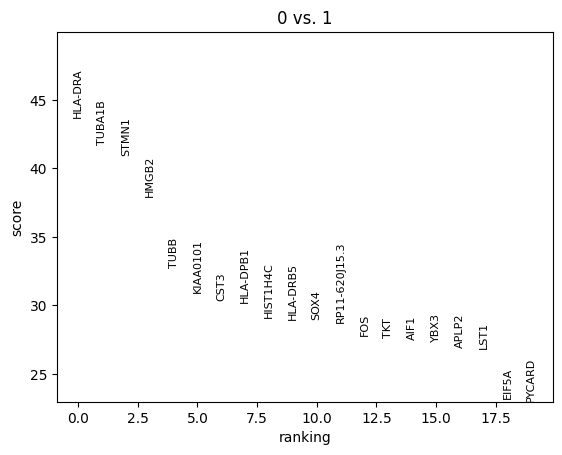

In [46]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


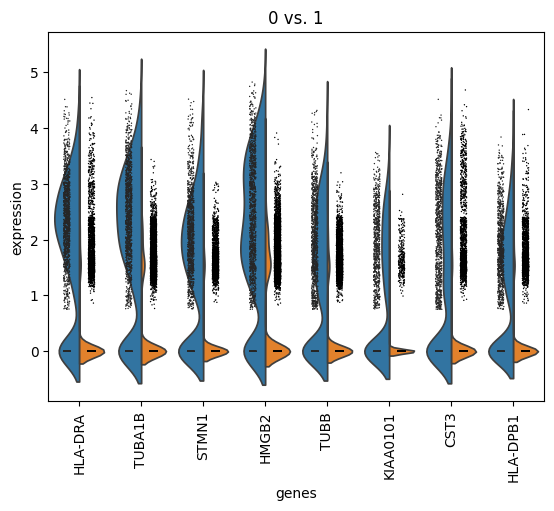

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [48]:
adata = sc.read(results_file)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


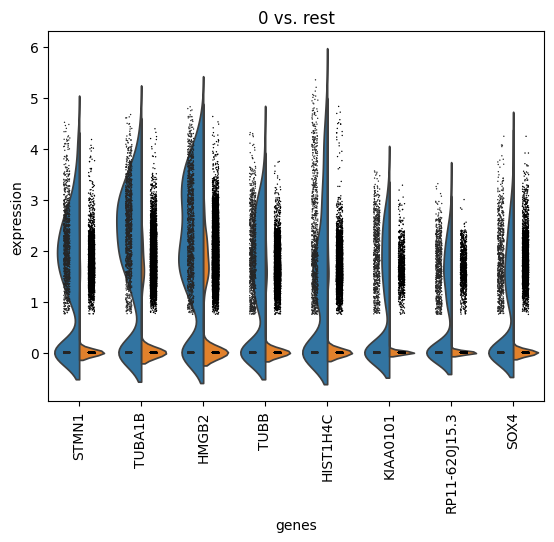

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

To compare a certain gene across groups, use the following.

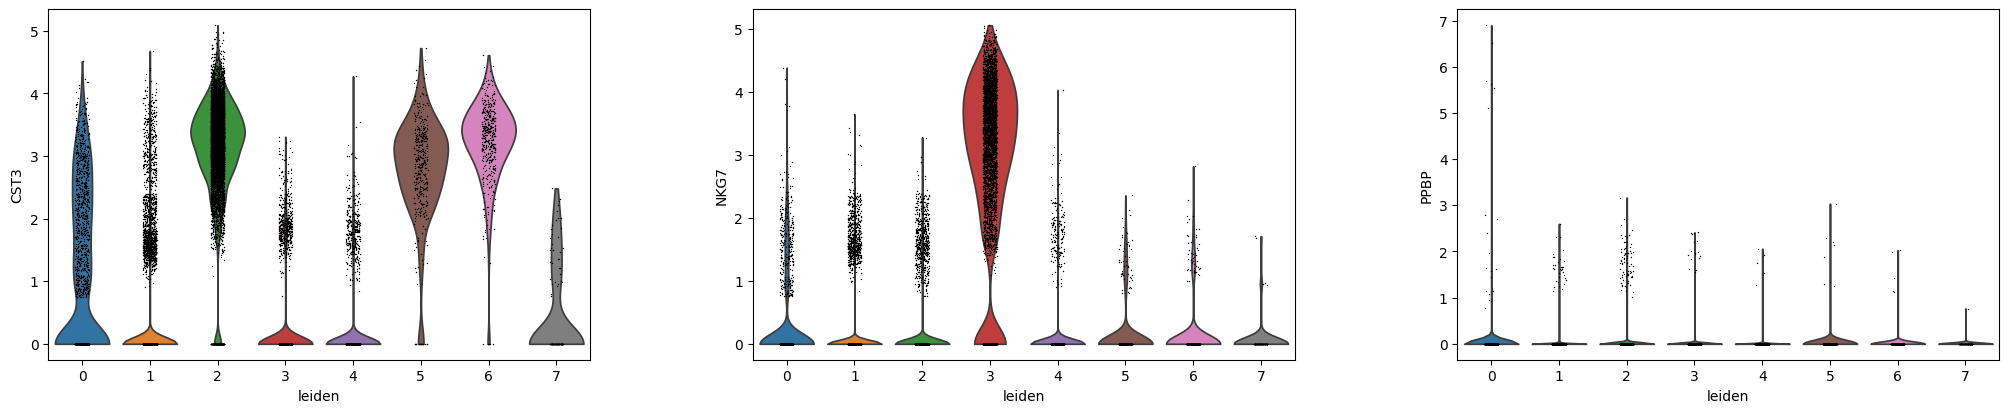

In [50]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

Actually let us mark the cell types.

In [54]:
new_cluster_names = [
    "Macro. and mono. prolif",
    "CD4 transitional memory",
    "Monocytes",
    "CD8 terminally exhausted",
    "B cells",
    "pDC",
    "mDC",
    "Plasma B cells ",
]
adata.rename_categories("leiden", new_cluster_names)

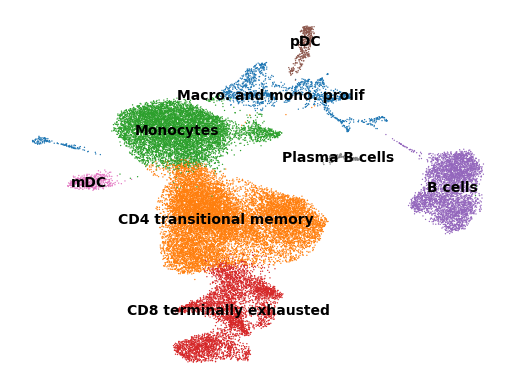

In [55]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

Now that we annotated the cell types, let us visualize the marker genes.

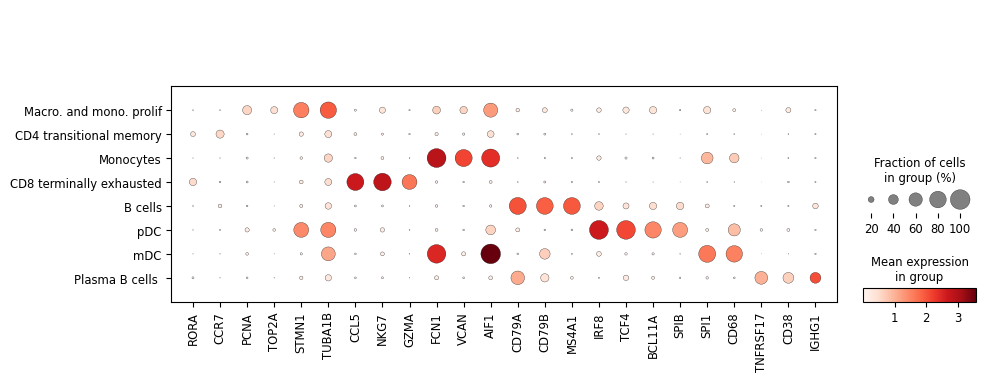

In [56]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

There is also a very compact violin plot.

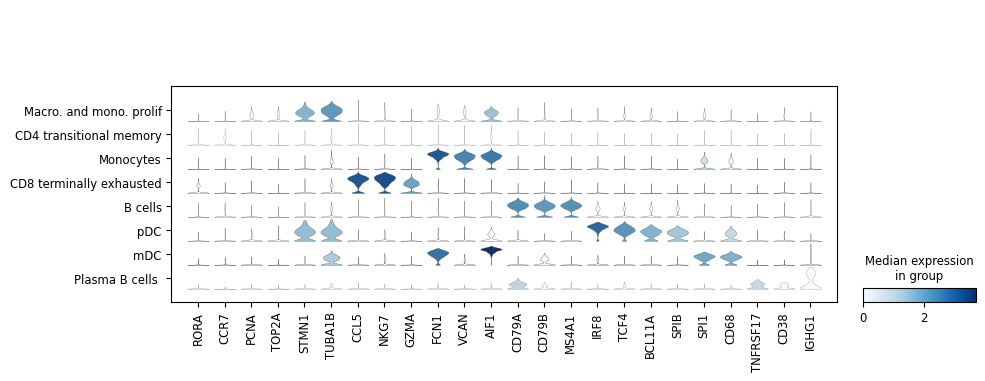

In [57]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

During the course of this analysis, the AnnData accumlated the following annotations.

In [58]:
adata

AnnData object with n_obs × n_vars = 31382 × 1008
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [59]:
adata.write(results_file, compression="gzip")

In [61]:
adata.raw.to_adata().write("./write/BI9.h5ad")